In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from selenium import webdriver
import re
import time
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp

seasons = ['1996-97', '1997-98', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08',
            '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19','2020-21']
def get_data(seasons_list):
    statistics = pd.DataFrame()
    for season in seasons_list:
        url = 'https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1&Season='+season+'&SeasonType=Regular%20Season'
        driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
        driver.get(url)
        time.sleep(3)
        table = driver.find_element_by_class_name('nba-stat-table__overflow')
        remove_endline = table.text.split('\n')
        row_to_string = ' '.join(remove_endline)
        split_lines = re.sub(r'\s\d{1,2}\s([A-Z])', r'\n\1', row_to_string)
        separate_teams = split_lines.split('\n')
        table_list = []
        for row in separate_teams:
            split_stats = row.split()
            table_list.append(split_stats[-27:])
        df = pd.DataFrame.from_records(table_list[1:], columns = table_list[0])
        df.insert(0, 'SEASON', season)
        statistics = pd.concat([statistics, df], ignore_index = True)
        driver.close()
    return statistics

statistics_df = get_data(seasons)
statistics_df
statistics_df.to_csv('nba_statistics_pergame.csv', index=False)

stats_df = pd.read_csv('nba_statistics_pergame.csv')
stats_df.rename(columns = {'WIN%' : 'WIN_PERCENT', 'FG%': 'FG_PERCENT', '3PM': 'THREE_PM', '3PA': 'THREE_PA', '3P%': 'THREE_P_PERCENT', 'FT%': 'FT_PERCENT', '+/-' : 'PLUS_MINUS'}, inplace=True)

stats_df


<ipython-input-3-ee3958d4ff7b>:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
<ipython-input-3-ee3958d4ff7b>:31: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  table = driver.find_element_by_class_name('nba-stat-table__overflow')


,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,1996-97,Bulls,82,69,13,0.841,48.1,103.1,40.0,84.4,...,30.0,45.1,26.1,13.5,8.7,4.0,3.5,19.7,0.2,10.8
1,1996-97,Jazz,82,64,18,0.780,48.4,103.1,38.2,75.8,...,29.4,40.2,26.8,15.4,9.1,5.1,4.5,24.1,0.2,8.8
2,1996-97,Heat,82,61,21,0.744,48.3,94.8,34.4,76.0,...,29.3,41.0,21.2,15.9,7.9,5.4,4.8,23.4,0.3,5.5
3,1996-97,Rockets,82,57,25,0.695,48.4,100.6,37.0,79.1,...,31.3,42.6,24.5,16.6,8.4,4.2,4.5,19.6,0.2,4.5
4,1996-97,Knicks,82,57,25,0.695,48.4,95.4,35.1,75.9,...,30.7,42.5,22.1,17.8,7.7,4.6,3.6,24.8,0.2,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2020-21,Cavaliers,72,22,50,0.306,48.4,103.8,38.6,85.8,...,32.3,42.8,23.8,15.5,7.8,4.5,5.9,18.2,20.2,-8.4
679,2020-21,Thunder,72,22,50,0.306,48.2,105.0,38.8,88.0,...,35.7,45.6,22.1,16.1,7.0,4.4,5.3,18.1,18.6,-10.6
680,2020-21,Magic,72,21,51,0.292,48.1,104.0,38.3,89.2,...,35.1,45.4,21.8,12.8,6.9,4.4,5.3,17.2,18.6,-9.3
681,2020-21,Pistons,72,20,52,0.278,48.4,106.6,38.7,85.6,...,33.1,42.7,24.2,14.9,7.4,5.2,5.8,20.5,20.4,-4.5


In [4]:
outcome = 'W'
x_cols = ['PTS', 'FGM', 'FGA', 'FG_PERCENT', 'THREE_PM', 'THREE_PA', 'THREE_P_PERCENT', 'FTM', 'FTA', 'FT_PERCENT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
for col in stats_df[x_cols]:
    stats_df[col] = (stats_df[col] - stats_df[col].mean())/stats_df[col].std()
stats_df

,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,1996-97,Bulls,82,69,13,0.841,48.1,0.518913,1.222776,0.578015,...,-0.521692,1.334849,1.970791,-0.885618,1.160327,-1.112880,-1.997073,-0.803449,0.2,10.8
1,1996-97,Jazz,82,64,18,0.780,48.4,0.518913,0.414951,-1.748224,...,-0.793965,-1.113813,2.308316,0.680354,1.608702,0.216595,-0.591901,1.655084,0.2,8.8
2,1996-97,Heat,82,61,21,0.744,48.3,-0.793862,-1.290456,-1.694126,...,-0.839344,-0.714032,-0.391885,1.092452,0.263576,0.579179,-0.170349,1.263954,0.3,5.5
3,1996-97,Rockets,82,57,25,0.695,48.4,0.123499,-0.123598,-0.855597,...,0.068235,0.085532,1.199305,1.669389,0.824045,-0.871157,-0.591901,-0.859325,0.2,4.5
4,1996-97,Knicks,82,57,25,0.695,48.4,-0.698962,-0.976302,-1.721175,...,-0.204039,0.035559,0.042076,2.658423,0.039389,-0.387712,-1.856556,2.046214,0.2,3.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,2020-21,Cavaliers,72,22,50,0.306,48.4,0.629629,0.594468,0.956706,...,0.522024,0.185477,0.861780,0.762773,0.151483,-0.508573,1.375341,-1.641585,20.2,-8.4
679,2020-21,Thunder,72,22,50,0.306,48.2,0.819428,0.684226,1.551790,...,2.064908,1.584712,0.042076,1.257291,-0.745268,-0.629434,0.532237,-1.697461,18.6,-10.6
680,2020-21,Magic,72,21,51,0.292,48.1,0.661262,0.459830,1.876382,...,1.792634,1.484767,-0.102578,-1.462555,-0.857362,-0.629434,0.532237,-2.200343,18.6,-9.3
681,2020-21,Pistons,72,20,52,0.278,48.4,1.072493,0.639347,0.902607,...,0.885056,0.135504,1.054651,0.268256,-0.296893,0.337456,1.234824,-0.356443,20.4,-4.5


In [5]:
predictors = '+'.join(stats_df[x_cols])
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     159.3
Date:                Mon, 06 Dec 2021   Prob (F-statistic):          3.79e-232
Time:                        16:51:58   Log-Likelihood:                -2113.1
No. Observations:                 683   AIC:                             4266.
Df Residuals:                     663   BIC:                             4357.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4275      0.207    194.995      0.000      40.020      40.835
PTS                15.2191     18.008      0.845      0.398     -20.140      50.578
FGM                -9.7953     12.476     -0.785      0.433     -34.292      14.701
FGA               -11.7767      5.201     -2.264      0.024     -21.990      -1.563
FG_PERCENT          3.3472      4.058      0.825      0.410      -4.622      11.316
THREE_PM           -8.3463      8.417     -0.992      0.322     -24.874       8.182
THREE_PA            4.3317      3.931      1.102      0.271      -3.388      12.051
THREE_P_PERCENT     2.3396      0.619      3.782      0.000       1.125       3.554
FTM                -6.0382      6.832     -0.884      0.377     -19.452       7.376
FTA                 1.4937      4.627      0.323      0.747      -7.592      10.579
FT_PERCENT          1.7235      1.703      1.012      0.312      -1.621       5.068
OREB                9.9919      6.129      1.630      0.104      -2.042      22.026
DREB               13.0121      9.298      1.399      0.162      -5.246      31.270
REB                -3.3794      8.429     -0.401      0.689     -19.930      13.171
AST                 1.6603      0.306      5.426      0.000       1.059       2.261
TOV                -5.9452      0.282    -21.085      0.000      -6.499      -5.392
STL                 4.7144      0.245     19.221      0.000       4.233       5.196
BLK                 0.3282      0.228      1.441      0.150      -0.119       0.775
BLKA               -1.4602      0.276     -5.293      0.000      -2.002      -0.919
PF                  1.0668      0.281      3.798      0.000       0.515       1.618
==============================================================================
Omnibus:                        0.330   Durbin-Watson:                   1.535
Prob(Omnibus):                  0.848   Jarque-Bera (JB):                0.251
Skew:                          -0.043   Prob(JB):                        0.882
Kurtosis:                       3.039   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(26.5, -0.5)

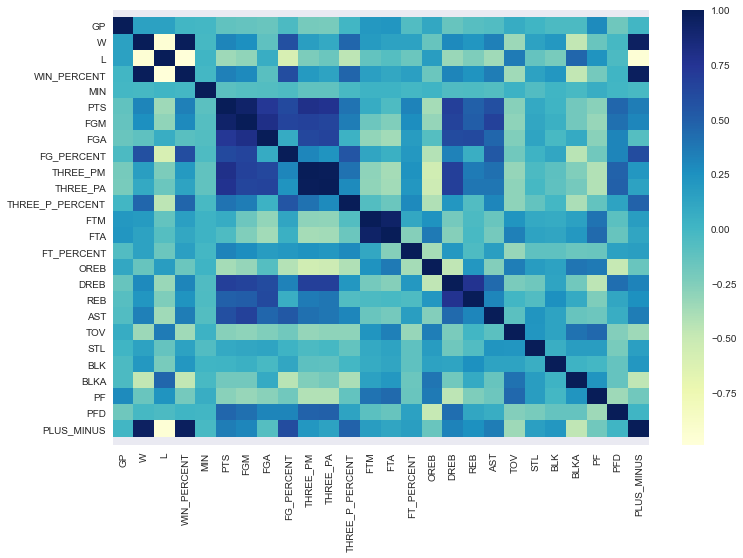

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(stats_df.corr(), ax=ax, cmap='YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [7]:
corr = stats_df.corr()
abs(corr).sort_values(by = 'W', ascending = False)['W']

W                  1.000000
WIN_PERCENT        0.987630
PLUS_MINUS         0.957403
L                  0.954820
FG_PERCENT         0.584550
BLKA               0.473050
THREE_P_PERCENT    0.460656
TOV                0.340699
AST                0.339096
PTS                0.309735
DREB               0.288497
FGM                0.261892
REB                0.216052
BLK                0.204147
FTM                0.189650
THREE_PM           0.163664
PF                 0.152819
GP                 0.150030
FT_PERCENT         0.142905
OREB               0.141912
STL                0.141734
FTA                0.138828
FGA                0.112984
THREE_PA           0.097688
PFD                0.016555
MIN                0.013961
Name: W, dtype: float64

In [8]:
new_xcols2 = ['PTS','THREE_P_PERCENT', 'FTM', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF']
predictors = '+'.join(new_xcols2)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=stats_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     113.5
Date:                Mon, 06 Dec 2021   Prob (F-statistic):          4.94e-145
Time:                        16:52:05   Log-Likelihood:                -2340.3
No. Observations:                 683   AIC:                             4705.
Df Residuals:                     671   BIC:                             4759.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          40.4275      0.287    140.655      0.000      39.863      40.992
PTS                -5.9377      0.541    -10.981      0.000      -6.999      -4.876
THREE_P_PERCENT     4.9816      0.360     13.851      0.000       4.275       5.688
FTM                 5.4595      0.350     15.602      0.000       4.772       6.147
OREB                2.8217      0.376      7.496      0.000       2.083       3.561
DREB                6.4117      0.504     12.714      0.000       5.421       7.402
AST                 2.7540      0.393      7.012      0.000       1.983       3.525
TOV                -3.7991      0.364    -10.446      0.000      -4.513      -3.085
STL                 4.0976      0.335     12.221      0.000       3.439       4.756
BLK                 0.9990      0.310      3.221      0.001       0.390       1.608
BLKA               -4.5209      0.342    -13.225      0.000      -5.192      -3.850
PF                 -0.6799      0.375     -1.811      0.071      -1.417       0.057
==============================================================================
Omnibus:                        0.331   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.847   Jarque-Bera (JB):                0.204
Skew:                          -0.011   Prob(JB):                        0.903
Kurtosis:                       3.082   Cond. No.                         4.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
formula

'W~PTS+THREE_P_PERCENT+FTM+OREB+DREB+AST+TOV+STL+BLK+BLKA+PF'

In [10]:
seasons_x = ['2021-22']
def get_data(seasons_list):
    statistics = pd.DataFrame()
    for season in seasons_list:
        url = 'https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1&Season='+season+'&SeasonType=Regular%20Season'
        driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
        driver.get(url)
        time.sleep(3)
        table = driver.find_element_by_class_name('nba-stat-table__overflow')
        remove_endline = table.text.split('\n')
        row_to_string = ' '.join(remove_endline)
        split_lines = re.sub(r'\s\d{1,2}\s([A-Z])', r'\n\1', row_to_string)
        separate_teams = split_lines.split('\n')
        table_list = []
        for row in separate_teams:
            split_stats = row.split()
            table_list.append(split_stats[-27:])
        df = pd.DataFrame.from_records(table_list[1:], columns = table_list[0])
        df.insert(0, 'SEASON', season)
        statistics = pd.concat([statistics, df], ignore_index = True)
        driver.close()
    return statistics

statistics_df_test = get_data(seasons_x)
statistics_df_test
statistics_df_test.to_csv('nba_statistics_pergame_current.csv', index=False)

stats_df_test = pd.read_csv('nba_statistics_pergame_current.csv')
stats_df_test.rename(columns = {'WIN%' : 'WIN_PERCENT', 'FG%': 'FG_PERCENT', '3PM': 'THREE_PM', '3PA': 'THREE_PA', '3P%': 'THREE_P_PERCENT', 'FT%': 'FT_PERCENT', '+/-' : 'PLUS_MINUS'}, inplace=True)

stats_df_test


<ipython-input-10-6a9912b50dfe>:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"/Users/willbernstein/Desktop/chromedriver")
<ipython-input-10-6a9912b50dfe>:9: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  table = driver.find_element_by_class_name('nba-stat-table__overflow')


,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,2021-22,Warriors,23,19,4,0.826,48.2,113.1,41.3,87.0,...,37.2,47.3,29.0,16.2,9.7,4.8,3.7,19.9,17.9,12.3
1,2021-22,Suns,23,19,4,0.826,48.0,111.6,42.2,87.9,...,36.2,44.9,26.1,13.6,9.0,4.0,3.7,18.8,19.5,6.5
2,2021-22,Nets,23,16,7,0.696,48.0,109.5,39.9,85.8,...,36.4,44.7,25.5,13.9,6.8,5.3,4.9,19.3,20.0,3.7
3,2021-22,Jazz,23,16,7,0.696,48.0,114.0,40.7,85.7,...,36.3,46.3,22.3,15.1,7.4,5.5,4.1,19.2,19.5,9.2
4,2021-22,Bulls,24,16,8,0.667,48.0,109.6,41.0,87.1,...,34.5,43.3,23.3,13.3,8.1,4.7,5.7,18.8,17.8,4.4
5,2021-22,Bucks,24,15,9,0.625,48.2,110.5,40.2,89.0,...,37.3,47.8,23.1,14.3,7.2,4.5,4.8,17.5,18.9,4.0
6,2021-22,Heat,24,14,10,0.583,48.4,107.7,39.3,85.7,...,34.1,44.5,24.4,14.4,7.4,2.7,4.9,20.5,20.0,3.2
7,2021-22,Wizards,24,14,10,0.583,48.6,105.3,39.3,85.5,...,36.8,45.8,23.6,13.9,6.1,5.4,4.3,18.7,19.8,-0.7
8,2021-22,Grizzlies,23,13,10,0.565,48.4,111.3,42.2,93.1,...,35.0,47.9,25.5,13.8,9.7,6.3,6.1,18.8,18.2,-0.5
9,2021-22,Hornets,25,14,11,0.560,48.6,115.5,42.7,93.0,...,33.6,44.2,26.3,13.0,9.0,5.4,5.1,19.3,19.5,-0.4


In [11]:
for col in stats_df_test[x_cols]:
    stats_df_test[col] = (stats_df_test[col] - stats_df_test[col].mean())/stats_df_test[col].std()
stats_df_test

,SEASON,TEAM,GP,W,L,WIN_PERCENT,MIN,PTS,FGM,FGA,...,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PLUS_MINUS
0,2021-22,Warriors,23,19,4,0.826,48.2,1.349704,0.825184,-0.576480,...,1.505251,1.510830,2.743191,1.478466,2.051848,-0.134356,-1.545473,0.590500,17.9,12.3
1,2021-22,Suns,23,19,4,0.826,48.0,0.990315,1.318104,-0.181430,...,0.854566,-0.155016,1.268175,-0.502983,1.308938,-1.142022,-1.545473,-0.214727,19.5,6.5
2,2021-22,Nets,23,16,7,0.696,48.0,0.487171,0.058420,-1.103214,...,0.984703,-0.293837,0.962999,-0.274354,-1.025924,0.495436,-0.008539,0.151285,20.0,3.7
3,2021-22,Jazz,23,16,7,0.696,48.0,1.565337,0.496571,-1.147108,...,0.919634,0.816727,-0.664605,0.640160,-0.389144,0.747352,-1.033162,0.078083,19.5,9.2
4,2021-22,Bulls,24,16,8,0.667,48.0,0.511130,0.660878,-0.532586,...,-0.251598,-1.265580,-0.155979,-0.731612,0.353767,-0.260314,1.016085,-0.214727,17.8,4.4
5,2021-22,Bucks,24,15,9,0.625,48.2,0.726764,0.222727,0.301409,...,1.570319,1.857881,-0.257704,0.030484,-0.601404,-0.512230,-0.136616,-1.166359,18.9,4.0
6,2021-22,Heat,24,14,10,0.583,48.4,0.055905,-0.270193,-1.147108,...,-0.511872,-0.432657,0.403510,0.106693,-0.389144,-2.779480,-0.008539,1.029714,20.0,3.2
7,2021-22,Wizards,24,14,10,0.583,48.6,-0.519117,-0.270193,-1.234897,...,1.244977,0.469676,-0.003391,-0.274354,-1.768835,0.621394,-0.777006,-0.287930,19.8,-0.7
8,2021-22,Grizzlies,23,13,10,0.565,48.4,0.918438,1.318104,2.101081,...,0.073744,1.927291,0.962999,-0.350564,2.051848,1.755019,1.528396,-0.214727,18.2,-0.5
9,2021-22,Hornets,25,14,11,0.560,48.6,1.924726,1.591948,2.057186,...,-0.837214,-0.640888,1.369900,-0.960241,1.308938,0.621394,0.247617,0.151285,19.5,-0.4


In [35]:
#W = 40.4275-5.9377(pts) +4.9816(3%)+5.4595(ftm)+2.8217(OREB)+6.4117(DREB)+2.7540(ast)-3.7991(TOV)+4.0974(STL)+0.9990(blk)-4.5209(BLKA)-0.6799(PF)
wins={}
for i in range(30):
    wins[stats_df_test.iloc[i]['TEAM']] = 40.4275 -5.9377*stats_df_test.iloc[i]['PTS']+4.9816*stats_df_test.iloc[i]['THREE_P_PERCENT']+5.4595*stats_df_test.iloc[i]['FTM']+2.8217*stats_df_test.iloc[i]['OREB']+6.4117*stats_df_test.iloc[i]['DREB']+2.7540*stats_df_test.iloc[i]['AST']-3.7991*stats_df_test.iloc[i]['TOV']+4.0974*stats_df_test.iloc[i]['STL']+stats_df_test.iloc[i]['BLK']-4.5209*stats_df_test.iloc[i]['BLKA']-0.6799*stats_df_test.iloc[i]['PF']
for key in wins.keys():
    print(key+ ' Predicted Wins: '+str(wins[key]))


Warriors Predicted Wins: 62.718790524591405
Suns Predicted Wins: 60.29970125839509
Nets Predicted Wins: 51.626670770745804
Jazz Predicted Wins: 46.48787723627499
Bulls Predicted Wins: 41.44634795969054
Bucks Predicted Wins: 47.76340468358441
Heat Predicted Wins: 39.48745069691053
Wizards Predicted Wins: 45.02551000845878
Grizzlies Predicted Wins: 44.78594520421028
Hornets Predicted Wins: 46.28101664001805
Celtics Predicted Wins: 50.86592554145939
Cavaliers Predicted Wins: 39.80960664261535
76ers Predicted Wins: 46.89268669310208
Hawks Predicted Wins: 50.7931642592632
Mavericks Predicted Wins: 34.10789879601079
Nuggets Predicted Wins: 23.850527307556447
Clippers Predicted Wins: 45.31375753601484
Lakers Predicted Wins: 50.714952482245835
Timberwolves Predicted Wins: 26.325036607401973
Knicks Predicted Wins: 44.65084999618062
Blazers Predicted Wins: 40.845004758345084
Raptors Predicted Wins: 31.589900580201117
Kings Predicted Wins: 31.169542273460486
Spurs Predicted Wins: 35.3122197894311